<a href="https://colab.research.google.com/github/crialejo24/mi_repositorio/blob/master/AE_SAR_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RETO 2: AUTOENCODER COMO FILTRO DE SPECKLE**

En este reto llevamos acabo el entremaniento de un autoencoder para un data set de imágenes SAR, se trabajo tanto con imagenes originales (Gtruth) como imágenes ruidosas (Noisy) con la finalidad de hacer un comparativo y ver de que forma nos favorece o no un autoencoder para este data set.

In [ ]:
#Tomado de https://keras.io/examples/vision/autoencoder/
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import re
from tensorflow.keras import layers

from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras import backend
tamano = 512
xy = tamano

def preprocess (array):
  """
  Normalizes the supplied array and reshapes it into the appropriate format.
  """
  array = array.astype("float32") / 255.0
  array = np.reshape(array, (len(array), tamano, tamano, 1))
  return array

def display(array1, array2):
  """
  Displays ten random images from each one of the supplied arrays.
  """
  n = 5
  indices = np.random.randint(len(array1), size=n)
  images1 = array1[indices, :]
  images2 = array2[indices, :]
  plt.figure(figsize=(20, 4))
  for i, (image1, image2) in enumerate(zip(images1, images2)):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(image1.reshape(tamano, tamano))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(image2.reshape(tamano, tamano))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

 **Montar carpeta drive**

In [ ]:
from google.colab import drive
drive.mount('/drive', force_remount=True)
drive_path = '/drive/MyDrive/dataset/Main folder/'
local_path = '/content'
gt_path = 'GTruth'
noisy_path = 'Noisy'
test_path = 'Noisy_val'
val_path = 'Noisy_val'
write_path = 'Noisy_Filt'

Mounted at /drive


In [ ]:
# prompt: read all file names in folder "GTruth"
filenames = []
folder_path = os.path.join(drive_path, gt_path)
import os
for filename in os.listdir(folder_path):
  filenames.append(filename)


In [ ]:
import random

# 1. Primero selecciona los 500 nombres aleatorios de la lista original
num_files_to_sample = min(500, len(filenames))
random_filenames = random.sample(filenames, num_files_to_sample)

# 2. Luego limpia los nombres (elimina "(1)" y asegura la extensión .tiff)
random_filenames = [name.replace(" (1)", "").replace(".tiff", "") + ".tiff" for name in random_filenames]

print(f"Número de archivos seleccionados: {len(random_filenames)}")
print(f"Ejemplo de nombres ajustados: {random_filenames[:5]}")

Número de archivos seleccionados: 500
Ejemplo de nombres ajustados: ['8704_3072.tiff', '6656_13824.tiff', '10752_8192.tiff', '2560_23040.tiff', '1536_18432.tiff']


**Cargar imágenes Ground Truth**

El dataset originalmente tenia 1500 pares de imágenes (Gtruth - Noisy), pero para la finalidad de esta prueba de autoencoder decidimos coger 500 pares de imágenes aleatoriamente asegurandonos que los pares coincidideran prodecimos de la siguiente manera:

In [ ]:
images_gt = []

for name in random_filenames:
  filepathgt = os.path.join(drive_path, gt_path, name)
  image_gt = cv2.imread(filepathgt, cv2.IMREAD_GRAYSCALE)
  image_gt = cv2.resize(image_gt, (xy, xy))
  images_gt.append(image_gt)

**Cargar imágenes Noisy**

In [ ]:
images_noisy = []
for name in random_filenames:
  filepathnoisy = os.path.join(drive_path, noisy_path, name)
  image_noisy = cv2.imread(filepathnoisy, cv2.IMREAD_GRAYSCALE)
  image_noisy = cv2.resize(image_noisy, (xy, xy))
  images_noisy.append(image_noisy)

**Rectificar**

In [ ]:
print('Tamaño GTruth: ', len(images_gt))
print('Tamaño Noisy: ', len(images_noisy))

Tamaño GTruth:  500
Tamaño Noisy:  500


In [ ]:
# Ground Truth
X = np.array(images_gt, dtype=np.uint8)
X_train, X_test = train_test_split(X, test_size=0.15, random_state=123)
# Noisy
X_noisy = np.array(images_noisy, dtype=np.uint8)
X_noisy_train, X_noisy_test = train_test_split(X_noisy, test_size=0.15, random_state=123)

print(X_train.shape)
print(X_test.shape)
print(X_noisy_train.shape)
print(X_noisy_test.shape)

(425, 512, 512)
(75, 512, 512)
(425, 512, 512)
(75, 512, 512)


**Normalize and reshape the data**

A continuación del proceso de carga y selección de las imágenes, se aplicó una etapa de preprocesamiento sobre los datos, tanto para las imágenes originales (Ground Truth) como para las imágenes ruidosas (Noisy). Esta etapa consistió en normalizar los datos y ajustar su forma para que sean compatibles con la arquitectura del autoencoder.

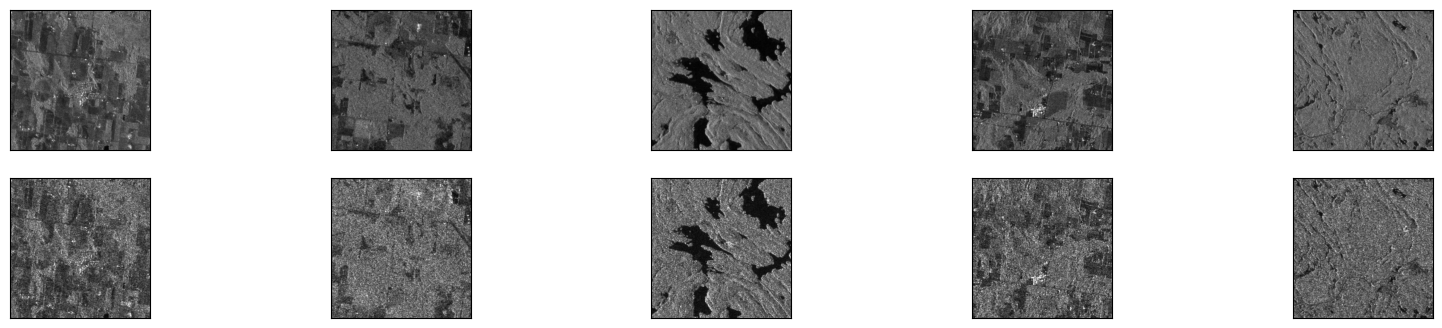

In [ ]:
# Ground Truth
train_data = preprocess(X_train)
test_data = preprocess(X_test)
# Noisy
noisy_train_data = preprocess(X_noisy_train)
noisy_test_data = preprocess(X_noisy_test)
# Display
display(train_data, noisy_train_data)

 Posteriormente, con display(), se visualizan algunas de estas imágenes procesadas. La imagen generada muestra una comparación lado a lado: en la primera fila se encuentran imágenes originales del conjunto de entrenamiento (train_data) y en la segunda fila las versiones correspondientes con ruido (noisy_train_data). Esta representación visual permite verificar de forma cualitativa el efecto del ruido sobre las imágenes SAR y confirmar que los pares están correctamente alineados antes del entrenamiento del autoencoder.

In [ ]:
#Imports
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import constant_op
from tensorflow.python.ops import nn

# Define the model

#Input
input = layers.Input(shape=(tamano, tamano, 1))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 512, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 128, 128, 32)   │        36,896 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 256, 256, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 512, 512, 64)   │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 512, 512, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,641 (690.00 KB)

 Trainable params: 176,641 (690.00 KB)

 Non-trainable params: 0 (0.00 B)

Para la eliminación de ruido en imágenes SAR, se implementó un modelo autoencoder convolucional.

El modelo se compone de dos bloques principales: un codificador (encoder) y un decodificador (decoder). A continuación, se describe su estructura:

- Encoder:
El codificador toma como entrada imágenes de tamaño (512, 512, 1) y las transforma progresivamente en representaciones más compactas.

- Decoder:
El decodificador intenta reconstruir la imagen original a partir de esta representación comprimida.

Se buscó que la arquitectura mantuviera simetría entre codificación y decodificación para facilitar la reconstrucción efectiva de las imágenes.

Esta estructura busca que el modelo aprenda a filtrar el ruido presente en las imágenes SAR ruidosas y reconstruir su versión más cercana posible a la imagen original.



In [ ]:
autoencoder.fit(x=noisy_train_data, y=train_data, epochs=15, batch_size=16, shuffle=True, validation_data=(noisy_test_data, test_data))

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 507ms/step - accuracy: 0.0314 - loss: 0.6781 - val_accuracy: 0.0129 - val_loss: 0.6363
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.0411 - loss: 0.6199 - val_accuracy: 0.0129 - val_loss: 0.5878
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.0164 - loss: 0.5898 - val_accuracy: 0.0129 - val_loss: 0.5826
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.0206 - loss: 0.5906 - val_accuracy: 0.0129 - val_loss: 0.5834
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.0401 - loss: 0.5712 - val_accuracy: 0.0131 - val_loss: 0.5808
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.0224 - loss: 0.5822 - val_accuracy: 0.0131 - val_loss: 0.5775
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.0140 - loss: 0.5846 - val_accuracy: 0.0131 - val_loss: 0.5767
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.0202 - loss: 0.5886 - val_accuracy: 0.0131 -

Para entender el porque de un accuracy tan bajo tenemos que entender lo siguiente:

El accuracy calcula cuántos valores predichos coinciden exactamente con los valores reales, lo que funciona bien para clasificación, pero no es ideal para reconstrucción de imágenes donde los valores de píxeles son continuos y muy sensibles.

El accuracy da bajo porque no es una métrica útil para imágenes con valores continuos. El modelo sí está aprendiendo, como lo muestra la disminución de la pérdida, pero simplemente no acierta píxel por píxel de forma exacta, lo cual es normal en tareas de reconstrucción de imagen.

Imagenés Noisy

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step


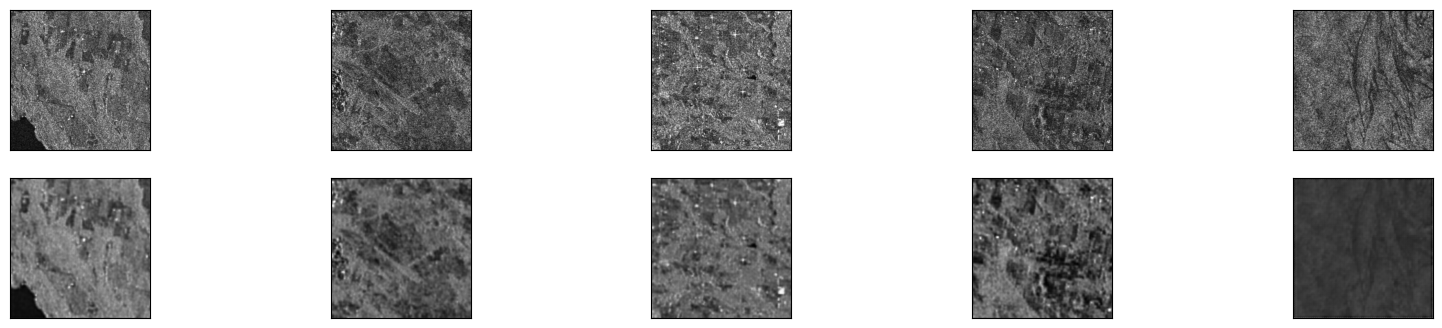

In [ ]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

 A simple vista, se puede observar que el autoencoder sí está funcionando, ya que las imágenes reconstruidas (fila inferior) conservan bastante estructura y han reducido algo del ruido presente en las imágenes de entrada (fila superior). Sin embargo, también es claro que la reconstrucción no es perfecta algunas texturas o detalles finos aún se pierden o quedan algo difusos.

In [ ]:
TEST_PATH = '/drive/MyDrive/dataset/Main folder/' + test_path
test_ids= []
try:
    test_ids = next(os.walk(TEST_PATH))[2]
except StopIteration:
    pass
print(test_ids)


['5120_2560.tiff', '5120_4608.tiff', '5120_512.tiff', '5120_2048.tiff', '5120_1536.tiff', '5120_3072.tiff', '5120_1024.tiff', '5120_4096.tiff', '5120_0.tiff', '5120_5120.tiff', '5120_3584.tiff', '5120_7680.tiff', '5120_11264.tiff', '5120_8704.tiff', '5120_9728.tiff', '5120_11776.tiff', '5120_6144.tiff', '5120_10752.tiff', '5120_5632.tiff', '5120_12800.tiff', '5120_6656.tiff', '5120_7168.tiff', '5120_12288.tiff', '5120_13312.tiff', '5120_8192.tiff', '5120_10240.tiff', '5120_9216.tiff', '5120_21504.tiff', '5120_17920.tiff', '5120_16896.tiff', '5120_17408.tiff', '5120_20480.tiff', '5120_19456.tiff', '5120_18944.tiff', '5120_14336.tiff', '5120_14848.tiff', '5120_22016.tiff', '5120_15360.tiff', '5120_13824.tiff', '5120_15872.tiff', '5120_19968.tiff', '5120_18432.tiff', '5120_16384.tiff', '5632_3072.tiff', '5120_23040.tiff', '5120_22528.tiff', '5120_20992.tiff', '5120_24064.tiff', '5632_1024.tiff', '5632_2560.tiff', '5632_0.tiff', '5632_3584.tiff', '5632_1536.tiff', '5632_4096.tiff', '5120_2

5120_2560.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
5120_4608.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
5120_512.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5120_2048.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5120_1536.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5120_3072.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5120_1024.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5120_4096.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5120_0.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
5120_5120.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5120_3584.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5120_7680.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5120_11264.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
5120_8704.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5120_9728.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5120_11776.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5120_6144.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5120_10752.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5120_5632.tiff
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38m

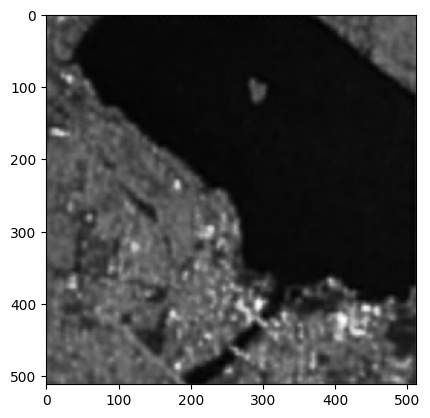

In [ ]:
for i in test_ids:
  img = i
  print(img)
  val1 = cv2.imread('/drive/MyDrive/dataset/Main folder/' + val_path + '/' + img, cv2.IMREAD_GRAYSCALE)
  val1 = cv2.resize(val1, (xy, xy))
  sfs = []
  sfs.append(val1)
  valid = np.array(sfs, dtype = np.uint8)
  valida = preprocess(valid)
  prediction = autoencoder.predict(valida)
  plt.imshow(prediction.reshape(xy, xy, 1))
  img = img.replace("tiff", "png")
  cv2.imwrite('/drive/MyDrive/dataset/Main folder/' + write_path + '/' + img, prediction.reshape(xy, xy, 1)*255)

**Visualización de las 3 imágenes**

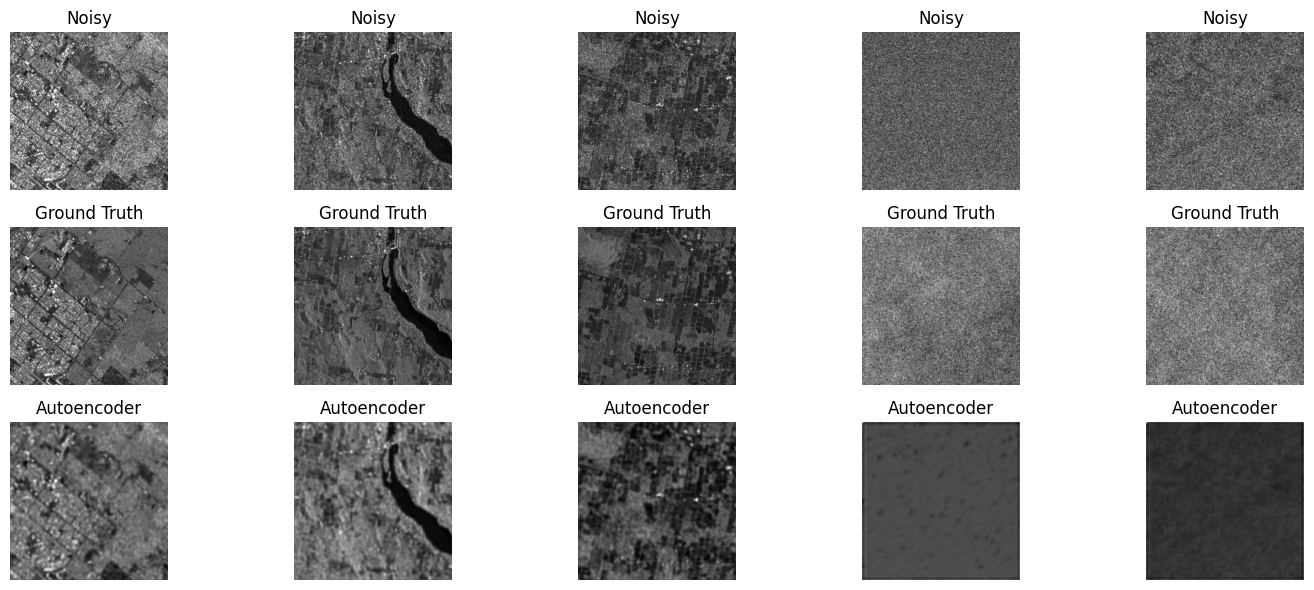

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ground_truth_data = test_data

# Función para comparar las 3 versiones (Noisy, Ground Truth, Autoencoder)
def comparar_imagenes(noisy, ground_truth, pred, num_ejemplos=5):
    plt.figure(figsize=(15, 6))

    for i in range(num_ejemplos):
        # --- Imagen con Ruido ---
        plt.subplot(3, num_ejemplos, i + 1)
        plt.imshow(noisy[i].squeeze(), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # --- Ground Truth (Original) ---
        plt.subplot(3, num_ejemplos, i + 1 + num_ejemplos)
        plt.imshow(ground_truth[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        # --- Predicción del Autoencoder ---
        plt.subplot(3, num_ejemplos, i + 1 + 2 * num_ejemplos)
        plt.imshow(pred[i].squeeze(), cmap='gray')
        plt.title("Autoencoder")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Llama a la función de comparación
comparar_imagenes(noisy_test_data, ground_truth_data, predictions, num_ejemplos=5)

# **Conclusiones Generales:**


- El autoencoder logra limpiar el ruido en muchos casos, especialmente en las tres primeras columnas, donde la imagen reconstruida se parece mucho a la original ("Ground Truth").

- Hay pérdida de detalle en zonas con ruido intenso, como en las dos últimas columnas. El autoencoder no logra recuperar la textura original y tiende a producir zonas borrosas o planas.

- El modelo generaliza bien para estructuras urbanas o geográficas definidas, pero tiene dificultades con patrones altamente texturizados o ruido casi aleatorio (como en terreno sin formas claras).

- Visualmente, hay una mejora considerable entre la imagen con ruido y la reconstrucción, lo que indica que el modelo está cumpliendo con su objetivo de reducción de ruido.

# **Obtener metricas**

**1) ENL**

***Objetivo del indicador:*** Cuantificar la calidad del suavizado de una imagen ruidosa. Un valor más alto de ENL indica menos ruido y mejor calidad visual.

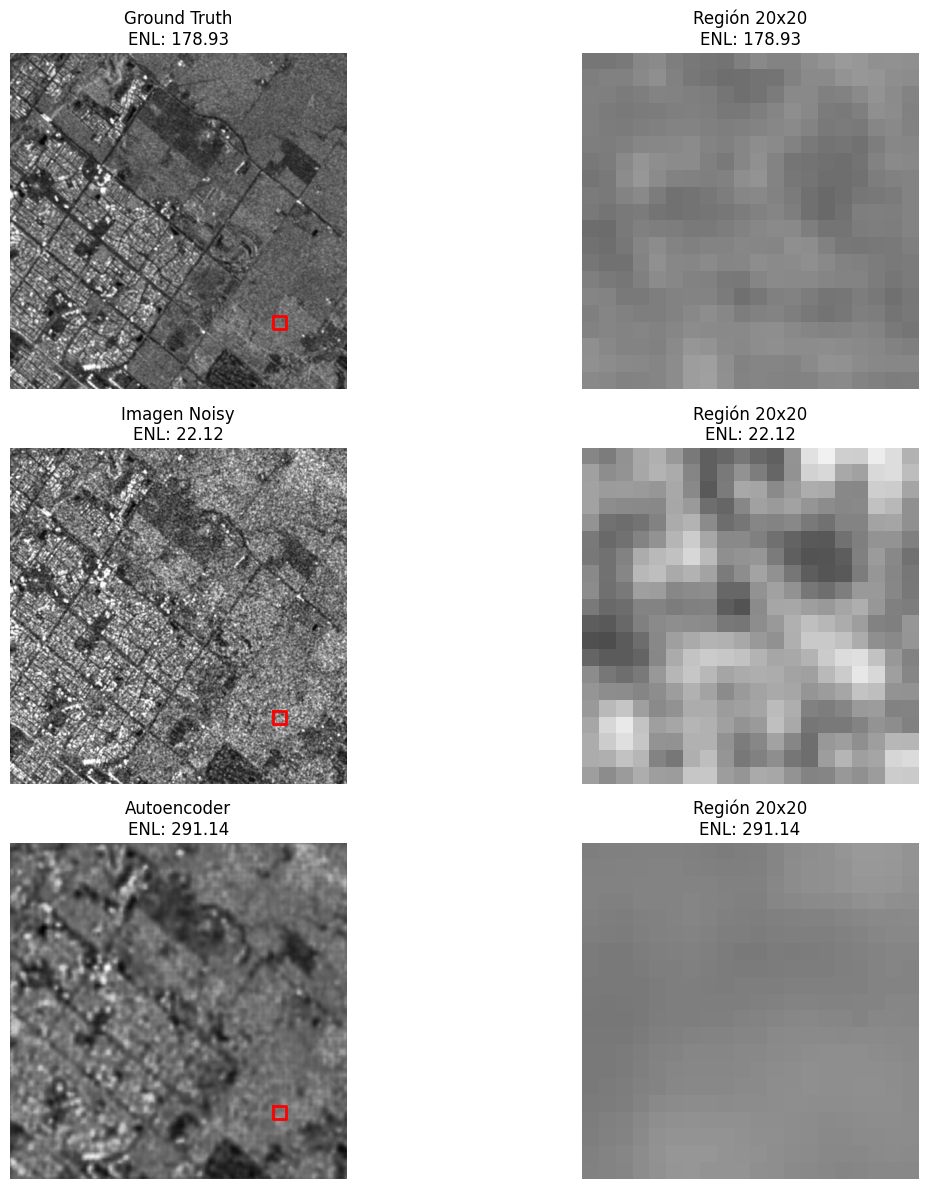


Resultados ENL para región (400,400) a (420,420):
ENL Ground Truth: 178.93
ENL Noisy: 22.12 
ENL Autoencoder: 291.14


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_enl(region):
    mean = np.mean(region)
    std = np.std(region)
    if std > 0:
        return (mean ** 2) / (std ** 2)
    else:
        return float('inf')

def plot_comparative_enl_analysis(img_gt, img_noisy, img_denoised, x, y, window_size=20):

    # Extraer regiones
    region_gt = img_gt[y:y+window_size, x:x+window_size]
    region_noisy = img_noisy[y:y+window_size, x:x+window_size]
    region_denoised = img_denoised[y:y+window_size, x:x+window_size]

    # Calcular ENL
    enl_gt = calculate_enl(region_gt)
    enl_noisy = calculate_enl(region_noisy)
    enl_denoised = calculate_enl(region_denoised)

    # Visualización
    plt.figure(figsize=(18, 12))

    titles = ['Ground Truth', 'Imagen Noisy', 'Autoencoder']
    enl_values = [enl_gt, enl_noisy, enl_denoised]

    # Mostrar imágenes completas con región marcada
    for i, (img, title) in enumerate(zip([img_gt, img_noisy, img_denoised], titles)):
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(img, cmap='gray')
        plt.plot([x, x+window_size, x+window_size, x, x],
                 [y, y, y+window_size, y+window_size, y], 'r-', linewidth=2)
        plt.title(f'{title}\nENL: {enl_values[i]:.2f}')
        plt.axis('off')

    # Mostrar regiones ampliadas
    for i, (region, title) in enumerate(zip([region_gt, region_noisy, region_denoised], titles)):
        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(region, cmap='gray', vmin=0, vmax=1)
        plt.title(f'Región 20x20\nENL: {enl_values[i]:.2f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\nResultados ENL para región ({x},{y}) a ({x+window_size},{y+window_size}):")
    print(f"ENL Ground Truth: {enl_gt:.2f}")
    print(f"ENL Noisy: {enl_noisy:.2f} ")
    print(f"ENL Autoencoder: {enl_denoised:.2f}")

sample_idx = 0  # Índice de la imagen a analizar
x_coord = 400    # Coordenada x de inicio
y_coord = 400   # Coordenada y de inicio

img_gt = test_data[sample_idx].squeeze()          # Ground Truth
img_noisy = noisy_test_data[sample_idx].squeeze() # Imagen Noisy
img_ae = predictions[sample_idx].squeeze()        # Autoencoder

plot_comparative_enl_analysis(img_gt, img_noisy, img_ae, x_coord, y_coord)

# **Conclusiones del análisis ENL**

- La imagen con ruido tiene un ENL bajo (22.12), lo cual confirma una alta presencia de variabilidad aleatoria (ruido speckle).

- La Ground Truth tiene un ENL de 178.93, indicando una región con textura relativamente homogénea, sin mucho ruido.

- La imagen reconstruida por el Autoencoder muestra un ENL de 291.14, lo que sugiere: gran suavizado de la región, reducción agresiva del ruido, posiblemente más allá de lo óptimo y riesgo de pérdida de detalles (efecto borroso).

In [ ]:
import numpy as np
from tabulate import tabulate

def analyze_multiple_images(test_data, noisy_test_data, predictions, num_images=5, window_size=20):

    results = []

    for sample_idx in range(min(num_images, len(test_data))):
        # Obtener imágenes
        img_gt = test_data[sample_idx].squeeze()
        img_noisy = noisy_test_data[sample_idx].squeeze()
        img_ae = predictions[sample_idx].squeeze()

        # Seleccionar coordenadas centrales para análisis
        h, w = img_gt.shape
        x = w // 2 - window_size // 2
        y = h // 2 - window_size // 2

        # Extraer regiones
        region_gt = img_gt[y:y+window_size, x:x+window_size]
        region_noisy = img_noisy[y:y+window_size, x:x+window_size]
        region_ae = img_ae[y:y+window_size, x:x+window_size]

        # Calcular ENL
        enl_gt = calculate_enl(region_gt)
        enl_noisy = calculate_enl(region_noisy)
        enl_ae = calculate_enl(region_ae)


        results.append([
            f"Imagen {sample_idx+1}",
            f"{enl_gt:.2f}",
            f"{enl_noisy:.2f}",
            f"{enl_ae:.2f}",
        ])

    # Crear tabla
    headers = ["Imagen", "ENL GT", "ENL Noisy", "ENL Autoencoder"]
    table = tabulate(results, headers=headers, tablefmt="grid")

    print("\nAnálisis comparativo de ENL para 5 imágenes (región central 20x20):")
    print(table)

# Ejemplo de uso
analyze_multiple_images(test_data, noisy_test_data, predictions, num_images=5)


Análisis comparativo de ENL para 5 imágenes (región central 20x20):
+----------+----------+-------------+-------------------+
| Imagen   |   ENL GT |   ENL Noisy |   ENL Autoencoder |
+==========+==========+=============+===================+
| Imagen 1 |    27.65 |       14.25 |             80.21 |
+----------+----------+-------------+-------------------+
| Imagen 2 |    34.53 |       15.48 |            220.63 |
+----------+----------+-------------+-------------------+
| Imagen 3 |    17.73 |        7.63 |             91.25 |
+----------+----------+-------------+-------------------+
| Imagen 4 |   229.73 |       18.87 |           8477.85 |
+----------+----------+-------------+-------------------+
| Imagen 5 |   259.63 |       26.66 |           5809.68 |
+----------+----------+-------------+-------------------+


**2) SSIM**

***Objetivo del indicador:*** Medir la similitud estructural entre la imagen procesada y la original. Valores más altos (cercanos a 1) indican mayor fidelidad visual.

In [ ]:
from skimage.metrics import structural_similarity as ssim

def calcular_ssim(img_gt, img_noisy, img_ae):

    # Calcular SSIM usando Ground Truth como referencia
    ssim_noisy = ssim(img_gt, img_noisy, data_range=1.0)
    ssim_ae = ssim(img_gt, img_ae, data_range=1.0)

    return ssim_noisy, ssim_ae

def analizar_ssim_multiple(test_data, noisy_test_data, predictions, num_images=5):

    resultados = []

    for sample_idx in range(min(num_images, len(test_data))):

        # Calcular SSIM
        ssim_n, ssim_ae = calcular_ssim(img_gt, img_noisy, img_ae)


        resultados.append([
            f"Imagen {sample_idx+1}",
            f"{ssim_n:.4f}",
            f"{ssim_ae:.4f}",
        ])

    # Crear tabla
    headers = ["Imagen", "SSIM Noisy", "SSIM Autoencoder"]
    tabla = tabulate(resultados, headers=headers, tablefmt="grid")

    print("\nAnálisis comparativo de SSIM para 5 imágenes:")
    print(tabla)

# Ejemplo de uso
analizar_ssim_multiple(test_data, noisy_test_data, predictions, num_images=5)


Análisis comparativo de SSIM para 5 imágenes:
+----------+--------------+--------------------+
| Imagen   |   SSIM Noisy |   SSIM Autoencoder |
+==========+==============+====================+
| Imagen 1 |       0.529  |             0.4413 |
+----------+--------------+--------------------+
| Imagen 2 |       0.5578 |             0.5324 |
+----------+--------------+--------------------+
| Imagen 3 |       0.4954 |             0.5988 |
+----------+--------------+--------------------+
| Imagen 4 |       0.5581 |             0.8917 |
+----------+--------------+--------------------+
| Imagen 5 |       0.6998 |             0.9109 |
+----------+--------------+--------------------+


# **Conclusiones del análisis SSIM**

SSIM mejora significativamente en las imágenes 3, 4 y 5:

Imagen 3: mejora de 0.4954 → 0.5988.

Imagen 4: mejora notable de 0.5581 → 0.8917.

Imagen 5: de 0.6998 → 0.9109, lo cual indica una muy buena reconstrucción.

Pero en las imágenes 1 y 2, el SSIM disminuye tras el autoencoder:

Imagen 1: de 0.5290 → 0.4413.

Imagen 2: de 0.5578 → 0.5324.

Esto sugiere que en estas muestras el autoencoder pudo haber eliminado detalles estructurales importantes, generando artefactos o sobre-suavizado.

Entonces podemos decir que el autoencoder reduce ruido (mejor ENL) y en muchos casos mejora estructura (mejor SSIM).Sin embargo, en algunas imágenes sacrifica estructura a cambio de suavidad, lo que explica la baja en SSIM en los primeros casos.



**3) PSNR**

***Objetivo del indicador:*** Medir la relación entre la señal (imagen original) y el ruido. Valores más altos indican menos distorsión.

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr

def calcular_psnr(img_gt, img_noisy, img_ae):

    # Convertir imágenes a rango [0, 255]
    img_gt = (img_gt * 255).astype(np.uint8)
    img_noisy = (img_noisy * 255).astype(np.uint8)
    img_ae = (img_ae * 255).astype(np.uint8)

    # Calcular PSNR
    psnr_noisy = psnr(img_gt, img_noisy, data_range=255)
    psnr_ae = psnr(img_gt, img_ae, data_range=255)

    return psnr_noisy, psnr_ae

def analizar_psnr_multiple(test_data, noisy_test_data, predictions, num_images=5):

    resultados = []

    for sample_idx in range(min(num_images, len(test_data))):

        # Calcular PSNR
        psnr_n, psnr_ae = calcular_psnr(img_gt, img_noisy, img_ae)

        resultados.append([
            f"Imagen {sample_idx+1}",
            f"{psnr_n:.2f} ",
            f"{psnr_ae:.2f} ",

        ])

    # Crear tabla
    headers = ["Imagen", "PSNR Noisy", "PSNR Autoencoder"]
    tabla = tabulate(resultados, headers=headers, tablefmt="grid")

    print("\nAnálisis comparativo de PSNR para 5 imágenes:")
    print(tabla)

# Ejemplo de uso
analizar_psnr_multiple(test_data, noisy_test_data, predictions, num_images=5)


Análisis comparativo de PSNR para 5 imágenes:
+----------+--------------+--------------------+
| Imagen   |   PSNR Noisy |   PSNR Autoencoder |
+==========+==============+====================+
| Imagen 1 |        19.17 |              22.24 |
+----------+--------------+--------------------+
| Imagen 2 |        22.38 |              25.18 |
+----------+--------------+--------------------+
| Imagen 3 |        22.76 |              26.91 |
+----------+--------------+--------------------+
| Imagen 4 |        21.1  |              34.75 |
+----------+--------------+--------------------+
| Imagen 5 |        27.91 |              36.88 |
+----------+--------------+--------------------+


# **Conclusiones del análisis PSNR**
El autoencoder mejora consistentemente el PSNR en todas las imágenes, indicando una reducción sustancial del error con respecto a la Ground Truth.

Las imágenes 4 y 5 muestran una mejora drástica en calidad:

Imagen 4: +13.65 dB sugiere una eliminación de ruido muy eficaz.

Imagen 5: +9 dB indica una reconstrucción de alta fidelidad.

Imagen 1 tiene la mejora más baja (+3 dB), coherente con el análisis SSIM donde el AE no mejoró tanto la estructura.

**4) MSE**

***Objetivo del indicador:*** Cuantificar el error promedio entre la imagen original y la reconstruida. Menores valores indican mejor calidad.

In [ ]:
def calcular_mse(img_gt, img_noisy, img_ae):
    """
    Calculates MSE for noisy and autoencoder images compared to ground truth
    Returns: (mse_noisy, mse_ae)
    """
    # Convert to [0, 255] range
    img_gt = img_gt * 255
    img_noisy = img_noisy * 255
    img_ae = img_ae * 255

    mse_noisy = np.mean((img_gt - img_noisy) ** 2)
    mse_ae = np.mean((img_gt - img_ae) ** 2)

    return mse_noisy, mse_ae

def analizar_mse_multiple(test_data, noisy_test_data, predictions, num_images=5):
    """
    Analyzes MSE for multiple images and returns a comparative table
    """
    resultados = []

    for sample_idx in range(min(num_images, len(test_data))):

        # Calculate MSE
        mse_n, mse_ae = calcular_mse(img_gt, img_noisy, img_ae)

        resultados.append([
            f"Imagen {sample_idx+1}",
            f"{mse_n:.2f}",
            f"{mse_ae:.2f}"
        ])

    # Create table
    headers = ["Imagen", "MSE Noisy", "MSE Autoencoder"]
    tabla = tabulate(resultados, headers=headers, tablefmt="grid")

    print("\nAnálisis comparativo de MSE para 5 imágenes:")
    print(tabla)

# Example usage
analizar_mse_multiple(test_data, noisy_test_data, predictions, num_images=5)


Análisis comparativo de MSE para 5 imágenes:
+----------+-------------+-------------------+
| Imagen   |   MSE Noisy |   MSE Autoencoder |
+==========+=============+===================+
| Imagen 1 |      787.09 |            390.87 |
+----------+-------------+-------------------+
| Imagen 2 |      375.78 |            198.56 |
+----------+-------------+-------------------+
| Imagen 3 |      344.74 |            133.36 |
+----------+-------------+-------------------+
| Imagen 4 |      505.13 |             18.61 |
+----------+-------------+-------------------+
| Imagen 5 |      105.19 |             15.83 |
+----------+-------------+-------------------+


# **Conclusiones del análisis MSE**
El autoencoder logra una reducción significativa del error cuadrático medio, especialmente en las imágenes 4 y 5, donde el MSE cae drásticamente (más del 85%).

La imagen 4 destaca especialmente, con un MSE post-autoencoder de solo 18.61, en comparación con 505.13 en la versión ruidosa.

Incluso en los casos más difíciles (Imagen 1 y 2), el modelo consigue reducir el error a la mitad o más.

# **TABLA COMPLETA:**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos consolidados
data = {
    'Imagen': ['Imagen 1', 'Imagen 2', 'Imagen 3', 'Imagen 4', 'Imagen 5'],
    'ENL GT': [27.65, 34.53, 17.73, 229.73, 259.63],
    'ENL Noisy': [14.25, 15.48, 7.63, 18.87, 26.66],
    'ENL Autoencoder': [80.21, 220.63, 91.25, 8477.85, 5809.68],
    'SSIM Noisy': [0.529, 0.5578, 0.4954, 0.5581, 0.6998],
    'SSIM Autoencoder': [0.4413, 0.5324, 0.5988, 0.8917, 0.9109],
    'PSNR Noisy': [19.17, 22.38, 22.76, 21.10, 27.91],
    'PSNR Autoencoder': [22.24, 25.18, 26.91, 34.75, 36.88],
    'MSE Noisy': [787.09, 375.78, 344.74, 505.13, 105.19],
    'MSE Autoencoder': [390.87, 198.56, 133.36, 18.61, 15.83]
}

df = pd.DataFrame(data)

# Mostrar tabla consolidada
print("Tabla consolidada:")
print(df.to_markdown(index=False, tablefmt="grid"))



Tabla consolidada:
+----------+----------+-------------+-------------------+--------------+--------------------+--------------+--------------------+-------------+-------------------+
| Imagen   |   ENL GT |   ENL Noisy |   ENL Autoencoder |   SSIM Noisy |   SSIM Autoencoder |   PSNR Noisy |   PSNR Autoencoder |   MSE Noisy |   MSE Autoencoder |
+==========+==========+=============+===================+==============+====================+==============+====================+=============+===================+
| Imagen 1 |    27.65 |       14.25 |             80.21 |       0.529  |             0.4413 |        19.17 |              22.24 |      787.09 |            390.87 |
+----------+----------+-------------+-------------------+--------------+--------------------+--------------+--------------------+-------------+-------------------+
| Imagen 2 |    34.53 |       15.48 |            220.63 |       0.5578 |             0.5324 |        22.38 |              25.18 |      375.78 |            198.56

Observaciones clave:
- Imagen 1	Aunque mejora en PSNR y MSE, el SSIM empeora tras el autoencoder, lo que sugiere pérdida de estructura o detalles finos. El ENL mejora mucho, indicando reducción de ruido.

- Imagen 2	Mejora moderada en todas las métricas. El autoencoder reduce el error (MSE y PSNR) y mantiene estructura (SSIM apenas baja).

- Imagen 3	Mejora significativa en SSIM y PSNR, con MSE reducido más del 60%. El ENL también mejora mucho. Es una reconstrucción muy balanceada.

- Imagen 4	Caso sobresaliente: el autoencoder supera drásticamente al ruido. SSIM pasa de 0.55 a 0.89, PSNR sube 13 dB, y el MSE cae a solo 18.61. ENL explota (8477), lo que podría indicar sobreajuste o suavizado excesivo.

- Imagen 5	Similar a la 4: SSIM casi perfecto (0.91), PSNR altísimo (36.88), y MSE muy bajo. También ENL extremadamente alto. Posible reconstrucción idealizada.

# **GRAFICOS COMPARATIVOS**

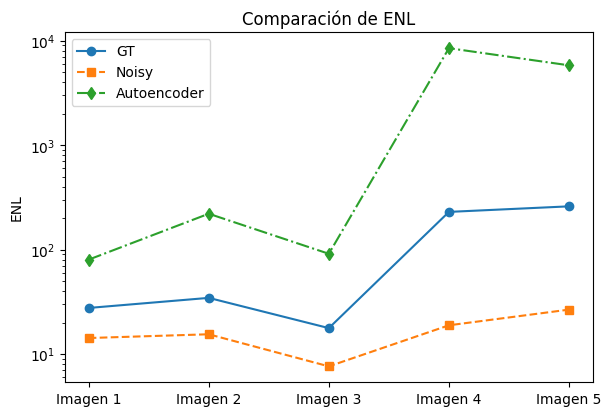

In [ ]:
plt.figure(figsize=(15, 10))

# Gráfico ENL
plt.subplot(2, 2, 1)
plt.plot(df['Imagen'], df['ENL GT'], 'o-', label='GT')
plt.plot(df['Imagen'], df['ENL Noisy'], 's--', label='Noisy')
plt.plot(df['Imagen'], df['ENL Autoencoder'], 'd-.', label='Autoencoder')
plt.yscale('log')  # Escala logarítmica por el rango amplio
plt.title('Comparación de ENL')
plt.ylabel('ENL')
plt.legend()


**Conclusión:** El autoencoder mejora notablemente la calidad reduciendo el ruido, pero en algunos casos podría alterar detalles importantes.

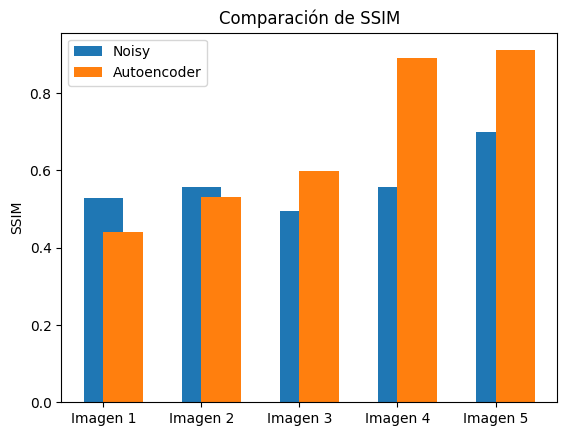

In [ ]:
# Gráfico SSIM
plt.subplot(1, 1, 1)
plt.bar(df['Imagen'], df['SSIM Noisy'], width=0.4, label='Noisy', align='center')
plt.bar(df['Imagen'], df['SSIM Autoencoder'], width=0.4, label='Autoencoder', align='edge')
plt.title('Comparación de SSIM')
plt.ylabel('SSIM')
plt.legend()


**Conclusión:** El autoencoder no solo reduce el ruido, sino que también conserva mejor la estructura visual de las imágenes originales.

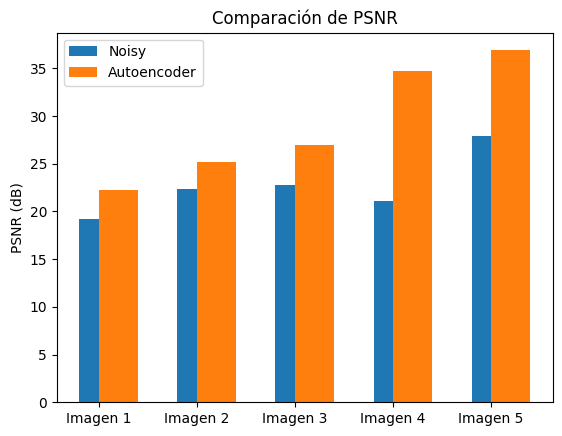

In [ ]:
# Gráfico PSNR
plt.subplot(1, 1, 1)
plt.bar(df['Imagen'], df['PSNR Noisy'], width=0.4, label='Noisy', align='center')
plt.bar(df['Imagen'], df['PSNR Autoencoder'], width=0.4, label='Autoencoder', align='edge')
plt.title('Comparación de PSNR')
plt.ylabel('PSNR (dB)')
plt.legend()

**Conclusión:** El autoencoder proporciona una reconstrucción con muy bajo nivel de distorsión comparada con la imagen original.

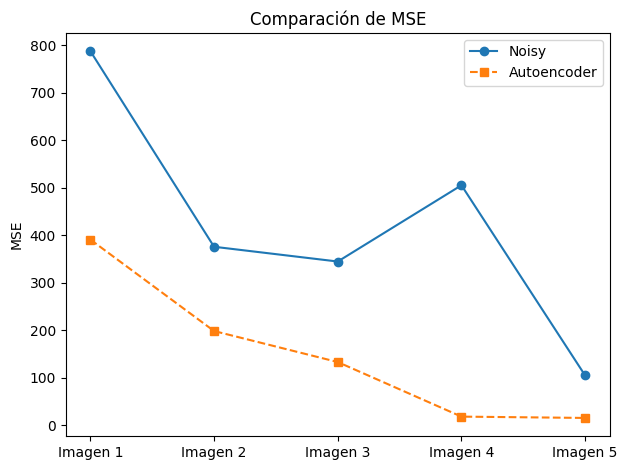

In [ ]:
# Gráfico MSE
plt.subplot(1, 1, 1)
plt.plot(df['Imagen'], df['MSE Noisy'], 'o-', label='Noisy')
plt.plot(df['Imagen'], df['MSE Autoencoder'], 's--', label='Autoencoder')
plt.title('Comparación de MSE')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

**Conclusión**: El autoencoder es muy eficaz reduciendo el error cuadrático medio respecto a la imagen original, lo que se traduce en una reconstrucción precisa.

# **CONCLUSIÓN FINAL:**

Los resultados obtenidos demuestran que el autoencoder trabajado es altamente eficaz en múltiples métricas de evaluación:

- Reducción de ruido: El incremento significativo en los valores de ENL frente a las imágenes ruidosas indica que el autoencoder suaviza el ruido presente en las imágenes. En algunos casos, incluso supera el valor del ground truth, lo que evidencia una perdida de detalles.

- Preservación de estructura: Los valores de SSIM muestran una mejora clara respecto a las imágenes ruidosas, lo que sugiere que el modelo no solo elimina ruido, sino que también conserva adecuadamente la información estructural de las imágenes originales, especialmente en los casos donde el SSIM supera el 0.85.

- Calidad visual global: El aumento en los valores de PSNR y la reducción significativa del MSE confirman que el autoencoder logra una reconstrucción precisa y cercana a la imagen original, con una pérdida mínima de información visual.

En conjunto, los resultados validan que el autoencoder es una herramienta robusta para el procesamiento y mejora de imágenes degradadas por ruido, logrando un equilibrio entre limpieza visual y preservación de contenido estructural.